# RFM clustering
this part is the clustering part to identify the profitable customer
RFM score is the indicator to evaluate the customer profitability.

In [1]:
import pandas as pd
dataset = pd.read_csv(r"C:\Users\joech\OneDrive\workspace\HKTV OpenDataBank\RFM_project\official_draft\dataset\rfm_data.csv", index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766903 entries, +++ytBmr09h9DnF+UqtW7XmrBZooefAaYkbr7quwvL4= to zzzt5x5IAuM+hS3F8PUVd4Z8aIOUhKMGHRYmL0RNXUA=
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f       766903 non-null  int64  
 1   r       766903 non-null  object 
 2   m       766903 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 23.4+ MB


In [2]:
import datetime
import tqdm
observe_date = datetime.datetime(year=2022, month=4, day=1)
for ind, row in tqdm.tqdm(dataset.iterrows()):
    dataset.loc[ind, 'r'] = (datetime.datetime.strptime(row.r, "%Y-%m-%d")-observe_date).days
dataset['r'] = dataset.r.astype("int")
dataset.head()


766903it [02:34, 4979.13it/s]


,f,r,m
hktv_ad_id,,,
+++ytBmr09h9DnF+UqtW7XmrBZooefAaYkbr7quwvL4=,2,-33,5472.0
++/XcJ8TwlaWjsE5Nu79DBhPuwXcAPNE/G4vqYXy4gY=,1,-16,524.5
++/o4fZf6mFzFvag92lTvQzVJNrPEgkDr2bmSOUZOAk=,2,-42,3769.5
++/zEZLENTmST6XwedyiTCkap1KRrXKHMsMH6C0kJQI=,1,-28,5745.0
++0Fkh5hM0ez6LoMx9Bg2zKV72wB7AiFs1UVXKz/lUc=,2,-31,99429.5


In [3]:
f,r,m = dataset.f, dataset.r, dataset.m
moq, year_consumption =500, 365/20
refined_dataset = dataset[
(f.between(year_consumption, f.quantile(0.99)))&
(m.between(moq*year_consumption, m.quantile(0.999)))&
(r > -30)
]
refined_dataset.describe()
# imply the domain knowledge of
# 1. the average consumption cycle is 20 days
# 2. the average GMV is 500 from 2021 annual report
# 3. the recency less than -30 be considered a inactivate users

,f,r,m
count,12097.000000,12097.000000,12097.000000
mean,21.738448,-5.525998,112200.068116
std,2.212176,5.162778,97996.110748
min,19.000000,-29.000000,9178.000000
25%,20.000000,-9.000000,50728.500000
50%,21.000000,-3.000000,80576.000000
75%,23.000000,-2.000000,134890.000000
max,26.000000,-1.000000,675601.000000


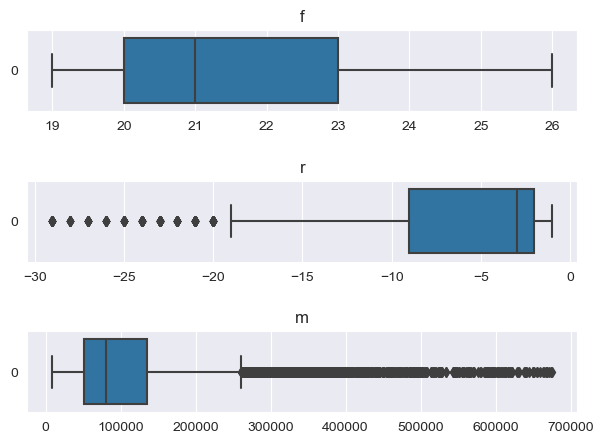

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=3)
for name, col in refined_dataset.iteritems():
    box = sns.boxplot(data=col, ax=ax[refined_dataset.columns.tolist().index(name)], orient="h")
    box.set_title(name)
fig.tight_layout(pad=2.0)


In [6]:
from sklearn.preprocessing import KBinsDiscretizer
RFM_score = KBinsDiscretizer(
    n_bins = 10,
    encode = 'ordinal',
    strategy = "quantile"
).fit_transform(X=refined_dataset).mean(axis=1)
RFM_score[RFM_score <= 5] = 0
RFM_score[RFM_score > 5] = 1
RFM_score = pd.Series(RFM_score, name="is_profitable")
RFM_score.index = refined_dataset.index
RFM_score.to_csv("dataset/cluster_result.csv")
RFM_score.value_counts()


C:\Users\joech\anaconda\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
C:\Users\joech\anaconda\lib\site-packages\sklearn\preprocessing\_discretization.py:230: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 1 are removed. Consider decreasing the number of bins.
  warnings.warn(


0.0    9790
1.0    2307
Name: is_profitable, dtype: int64

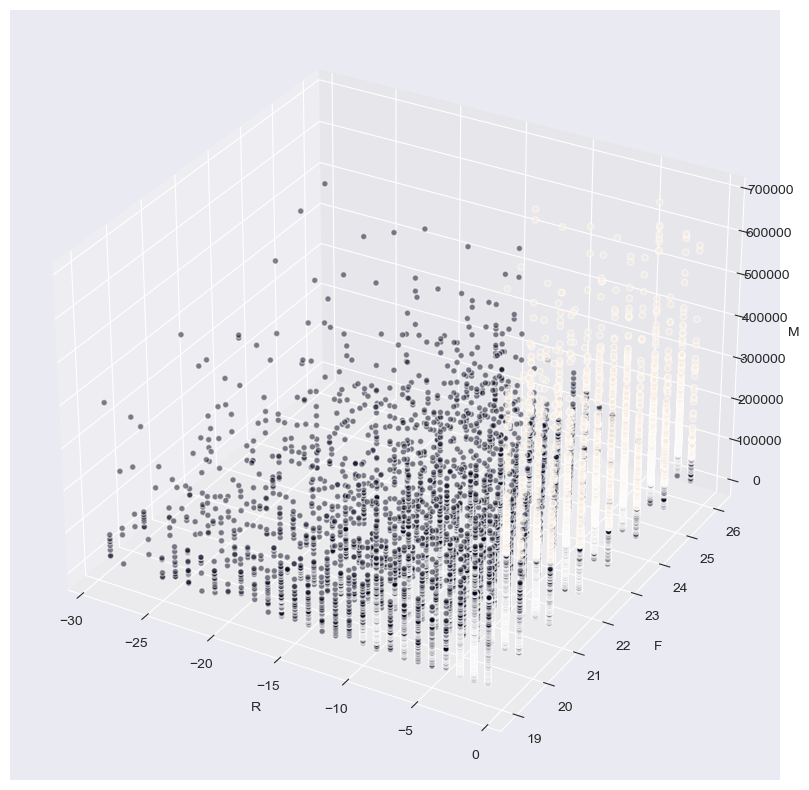

In [13]:
from mpl_toolkits import mplot3d
import seaborn as sns
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection="3d")
display = refined_dataset.merge(
    RFM_score, on="hktv_ad_id"
)
ax.set_xlabel("R")
ax.set_ylabel("F")
ax.set_zlabel("M")
sc = ax.scatter3D(
    display.r,
    display.f,
    display.m,
    c = RFM_score,
    alpha=0.5,
    edgecolor = "white"
)
